

# Predicción de Series Temporales utilizando FbProphet

La predicción de series temporales es de los casos más habituales y aplicables dentro del Machine Learning. Por ejemplo, models de 'forecasting' se pueden encontrar en para la predicción de precios, demanda, temperatura,  tiempo de respuesta, ventas, ritmo cardiaco, producción, etc. 

El gran reto se encuentra en que, a diferencia de algunos otros casos de Machine Learning, la predicción a futuro depende en gran medida, de los datos históricos de la serie. Es decir, por ejemplo si queremos predecir la temperatura media por hora, el dato más relevante que podemos utilizar es la misma serie de temperaturas por hora. A este tipo de modelos se los llama **Auto-regresivos.** 

En la práctica, los modelos auto-regresivos pueden desarrollarse sin ninguna otra variable auxiliar (covariantes), sin embargo, es común añadir regresores externos para complementar el poder predictivo del modelo. 

## Caso de uso: Predicción de la demanda de Bicicletas en una plataforma de BikeSharing en Washington DC. 

Reto: Predecir la demanda del siguiente mes!



# Importamos paquetes y definimos helpers

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.metrics import mean_squared_error , r2_score 
import seaborn as sns
from fbprophet import Prophet



def get_median_filtered(signal, threshold=3):
    
    """
    Función que nos permite sacar outliers utilizando el método de la mediana
    filtrada. Es bastante robusto a ruido, por lo que es ideal para series 
    temporales. 
     
    Directamente reemplaza outliers con la mediana!
    Info sobre el método en 
    https://en.wikipedia.org/wiki/Median_filter 
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana    
    :return:   array igual a serie con los outliers reemplazados. 
    
    """
    
    signal = signal.copy()
    difference = np.abs(signal - np.median(signal))
    median_difference = np.median(difference)
    if median_difference == 0:
        s = 0
    else:
        s = difference / float(median_difference)
    mask = s > threshold
    signal[mask] = np.median(signal)
    return signal

def plot_outliers_signal(signal, threshold = 3, return_mask = True):
    
    """
    Funcion que plotea los resultados de la funcion
    get_median_filtered
    
    :param signal: una serie o señal
    :param threshold: desviaciones respecto a la mediana   
    :param return_mask: Si es True, devuelve los índices donde hubo reemplazo 
    :return:  in plot
    
    """
    
    
    kw = dict(marker='o', linestyle='none', color='r', alpha=0.35)

    mds = get_median_filtered(signal, threshold=threshold)
    outlier_idx = np.where(mds != signal)[0]
    plt.figure(figsize=(10,8))

    plt.plot(signal, color = "darkblue")
    plt.plot(outlier_idx,signal[outlier_idx],**kw, 
            label = "Outliers")
    plt.title("Detección de Outliers con cutoff {}".format(threshold))
    plt.legend()
    plt.show();
    if return_mask: 
      return outlier_idx


def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) 

def evaluate(test_features, test_labels):
    print('Mean squared error: %.2f'% mean_squared_error(test_features, test_labels))
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: %.2f'%r2_score(test_features, test_labels))
    print('MAPE: %.2f'%  mean_absolute_percentage_error(test_features, test_labels))

## Cargamos los Datos y exploración inicial 

In [ ]:
#gdrive location:
url = 'https://raw.githubusercontent.com/patofw/imf_master/master/Notebooks/data/hour.csv'
df = pd.read_csv(url,parse_dates = ["dteday"]) 

In [ ]:
df.head(2)

,instant,dteday,hr,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,0,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,"Clear, Few clouds, Partly cloudy, Partly cloudy",0.22,0.2727,0.80,0.0,8,32,40


In [ ]:
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   instant     17379 non-null  int64         
 1   dteday      17379 non-null  datetime64[ns]
 2   hr          17379 non-null  int64         
 3   weathersit  17279 non-null  object        
 4   temp        17280 non-null  float64       
 5   atemp       17279 non-null  float64       
 6   hum         17279 non-null  float64       
 7   windspeed   17279 non-null  float64       
 8   casual      17379 non-null  int64         
 9   registered  17379 non-null  int64         
 10  cnt         17379 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 1.5+ MB
None


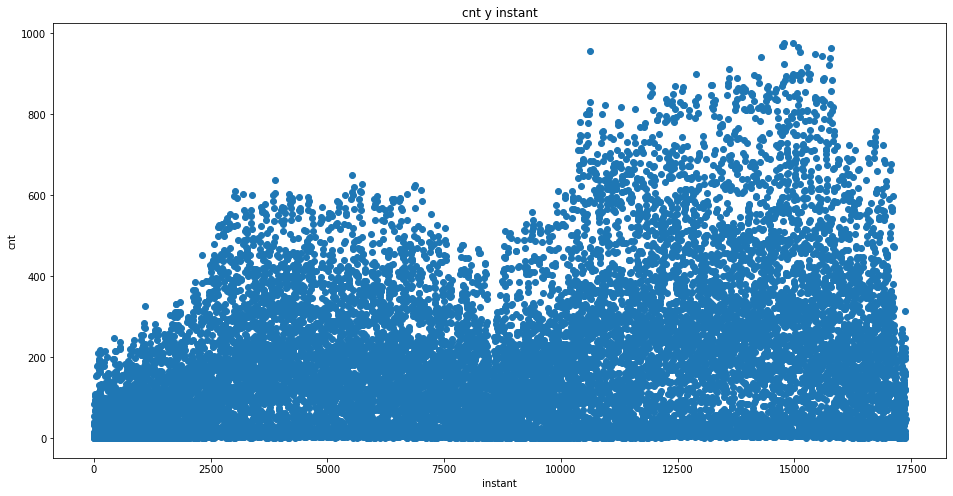

In [ ]:
x = 'instant'
y = 'cnt'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

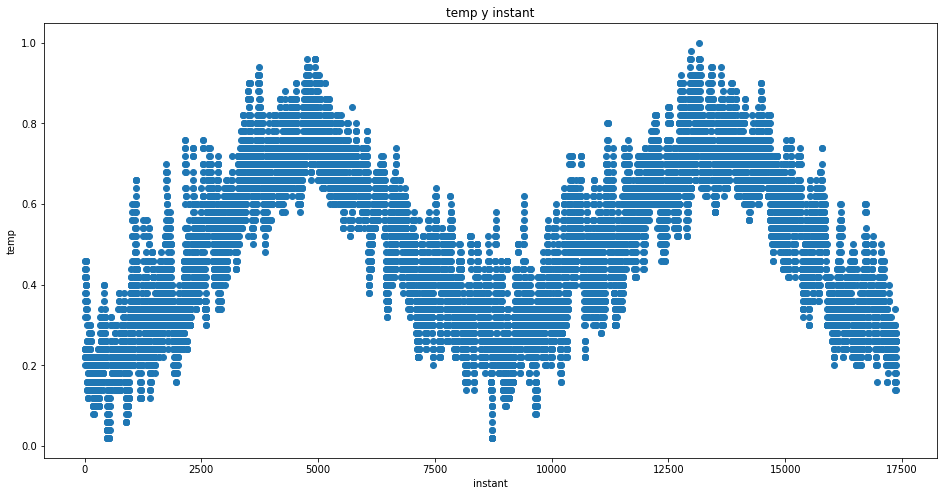

In [ ]:
x = 'instant'
y = 'temp'
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(df[x], df[y])
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_title(f'{y} y {x}')
plt.show()

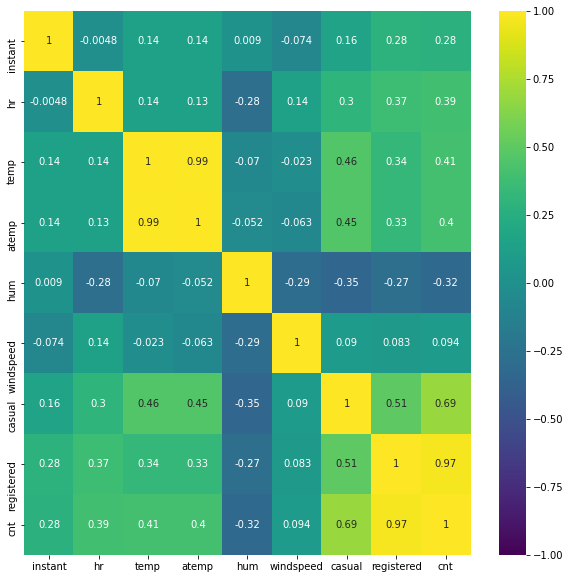

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap="viridis", vmin = -1, vmax = 1)

# Formato Datos 

Los datos están por hora, lo que dificulta en gran medida el análisis ya que se agrega muchísimo ruido de horas poco útiles. Para este caso de uso, trabajaremos con predicción de la demanda diaria. 

In [ ]:
df_byday = df.groupby('dteday')['cnt'].sum().reset_index() # Sum of cnt by day 

In [ ]:
df_byday.head()

,dteday,cnt
0,2011-01-01,985
1,2011-01-02,801
2,2011-01-03,1349
3,2011-01-04,1562
4,2011-01-05,1600


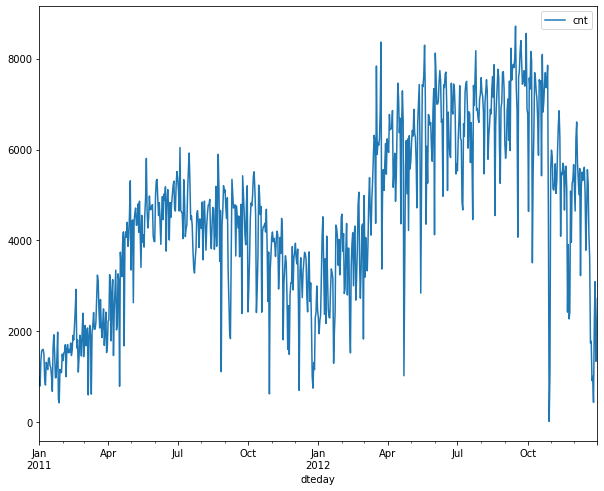

In [ ]:
df_byday.plot(x='dteday',y='cnt', figsize=(10,8));

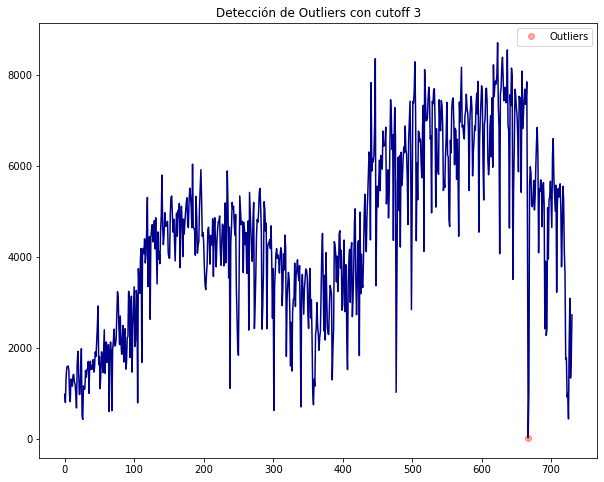

In [ ]:
# Outliers
indices = plot_outliers_signal(df_byday.cnt.values, threshold = 3)


In [ ]:
df_byday.iloc[indices]

,dteday,cnt
667,2012-10-29,22


Agregamos todas las variables que nos eran útiles. Sin embargo, no todas las podemos tratar de la misma forma

# Feature Engineering ( Creamos variables a raíz de nuestros datos)

In [ ]:
# ha llovido ??
rain_flag =['Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds',
            'Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog']
df['rain'] = [1 if x in rain_flag else 0 for x in df.weathersit.values]


In [ ]:

# Con las fechas y dt. podemos extraer variables relevantes! Por ejemplo 
df_byday["dayofweek"] = df_byday.dteday.dt.dayofweek # to know working day or not if monday(1) -friday (5) yes + if holiday 
df_byday["dayofyear"]= df_byday.dteday.dt.dayofyear
# La temporada influye muchísimo, si hace frío no se sale a montar bicicleta
conditions = [
    (df_byday['dayofyear'] >= 61) & (df_byday['dayofyear'] <= 150),
    (df_byday['dayofyear'] >= 151) & (df_byday['dayofyear'] <= 240),
    (df_byday['dayofyear'] >= 241) & (df_byday['dayofyear'] <= 330),
    (df_byday['dayofyear'] >= 331) |  (df_byday['dayofyear'] <= 60)
    ]
#create a list of the values we want to assign for each condition
values = [1, 2, 3, 4]
#create a new column and use np.select to assign values to it using our lists as arguments
df_byday['season'] = np.select(conditions, values)
holidays =  ["2011-01-01","2011-01-17","2011-02-21","2011-04-15",
             "2011-05-30","2011-07-04","2011-09-05","2011-11-11",
             "2011-11-24","2011-12-24","2011-12-25","2011-12-26",
             "2012-01-02","2012-01-16","2012-01-20","2012-04-16",
             "2012-05-28","2012-07-04","2012-09-03","2012-11-12",
             "2012-11-22","2012-12-24","2012-12-25"] 
  
conditions2 = [
    (df_byday['dayofweek'].isin([1,2,3,4,5])) & (~df_byday['dteday'].isin(holidays)),  #workdays
    (df_byday['dayofweek'].isin([6,0]))
    ]
values2 = [1,0]
#create a new column and use np.select to assign values to it using our lists as arguments
df_byday['is_workday'] = np.select(conditions2, values2)

# Re append the temperature and rain flag 
df_byday['temp'] = df.groupby('dteday')['temp'].mean().values # mean temp
df_byday['rain'] = df.groupby('dteday')['rain'].mean().values # mean of rain**
# ** Si llueve todo el día, la media estará cerca de 1, si llueve poco, cerca a 0



In [ ]:
df_byday.head()

,dteday,cnt,dayofweek,dayofyear,season,is_workday,temp,rain
0,2011-01-01,985,5,1,4,0,0.344167,0.083333
1,2011-01-02,801,6,2,4,0,0.363478,0.217391
2,2011-01-03,1349,0,3,4,0,0.197143,0.000000
3,2011-01-04,1562,1,4,4,1,0.200000,0.000000
4,2011-01-05,1600,2,5,4,1,0.226957,0.000000


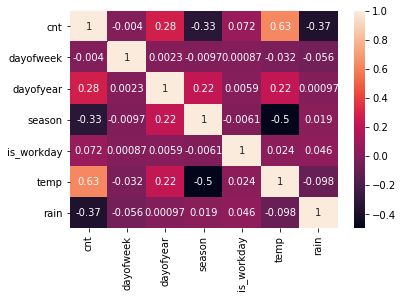

In [ ]:
# Veamos correlación entre variables 
sns.heatmap(df_byday.dropna().corr(), annot=True);

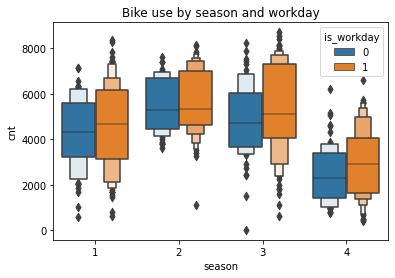

In [ ]:
sns.boxenplot(data = df_byday, x ='season', hue='is_workday',y='cnt' )
plt.title('Bike use by season and workday');

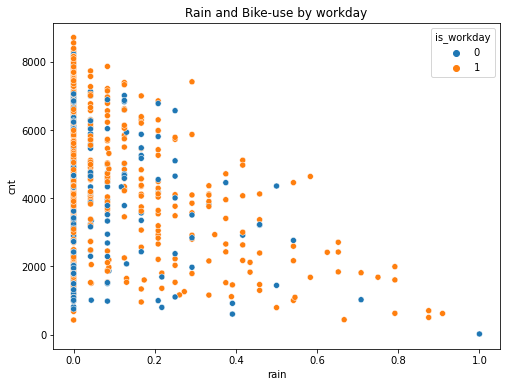

In [ ]:
fig = plt.figure(figsize=(8,6))
sns.scatterplot(data = df_byday, x ='rain', y='cnt', hue='is_workday')
plt.title('Rain and Bike-use by workday');

In [ ]:
abs(df_byday.corr()['cnt']).sort_values(ascending=False)

cnt           1.000000
temp          0.627631
rain          0.369099
season        0.330136
dayofyear     0.277433
is_workday    0.097083
dayofweek     0.003985
Name: cnt, dtype: float64

# Modelo de Machine Learning

In [ ]:
# separación 

ext_reg = ["temp",'rain','season','dayofyear','is_workday']
target = 'cnt' # our target var
train_cut = "2012-12-01"
# Separamos test de train
train = df_byday[df_byday.dteday < train_cut]
test = df_byday.copy()
# Formato para  Prophet 
train_proph = train[['dteday',target] + ext_reg]
#test dataset
X_test = test[train_proph.columns]
y_test = test[target]
X_test[target] = np.nan # quitamos valores del X_test en la target var 
 
# Llenamos NA ->  Usamos la temperatura del día anterior para llenar nulos 

train_proph['temp'] = train_proph.temp.fillna(method='ffill') # forward fill
X_test['temp'] = X_test.temp.fillna(method='ffill') # forward fill

# Renombramos la variable cnt cnt name a y como pide Prophet 
train_proph.rename(columns={target:'y','dteday':'ds'}, inplace=True)
X_test.rename(columns={target:'y','dteday':'ds'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

In [ ]:
# Try basic Prophet model first, adding external regressors (covariates)
m = Prophet(yearly_seasonality=True)
for reg in ext_reg: # adding regressors to the Prophet model 
  m.add_regressor(reg, 
                mode='additive')
# Train the model.
m.fit(train_proph)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


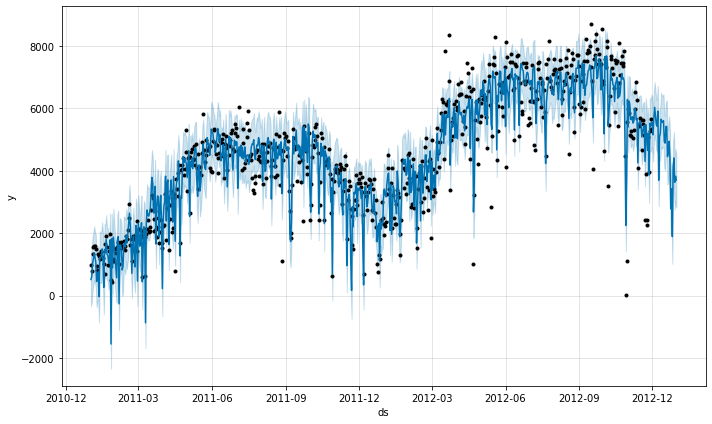

In [ ]:
# predict
forecast = m.predict(X_test)
fig = m.plot(forecast);

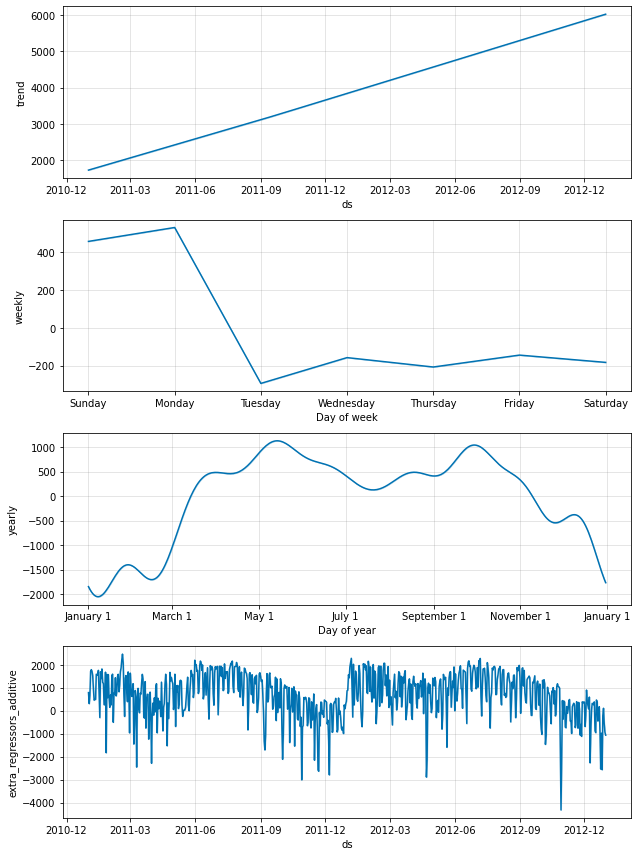

In [ ]:
fig = m.plot_components(forecast);

In [ ]:
predicted = forecast[forecast.ds>=train_cut].yhat
real = y_test[-len(predicted):]

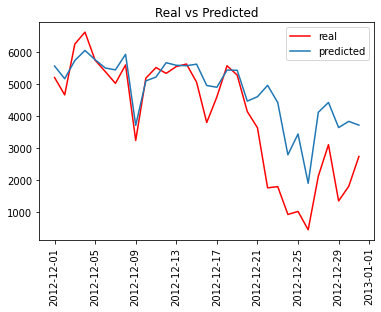

In [ ]:
x = X_test.ds[-len(predicted):]
plt.plot(x,real,c='red',label='real')
plt.plot(x,predicted,label='predicted')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Real vs Predicted');

In [ ]:
# imprimios evaluación
evaluate(real,predicted)

Mean squared error: 1581519.67
Coefficient of determination: 0.50
MAPE: 0.56


Results are still not good. Let's try to improve the model with fine tuning 

In [ ]:
import itertools 
from fbprophet.diagnostics import performance_metrics
from fbprophet.diagnostics import cross_validation

cv_forecast_horizon = '30 d'

TRAIN_GRID = {  
  'changepoint_prior_scale': [0.5,0.7],
  'seasonality_prior_scale': [5,10],#  Keep locked
  'yearly_seasonality': [10],
  'seasonality_mode': ['additive'], # (multiplicative may be explored, but later)
  'changepoint_range': [0.8,0.9],
  'holidays_prior_scale':[1]
}

all_params = [
  dict(zip(
    TRAIN_GRID.keys(),
    v)) for v in itertools.product(
    *TRAIN_GRID.values())]
tuning_results = pd.DataFrame()
# Use cross validation to evaluate all parameters # it can be parallelized.
i = 1
n_params = len(all_params)
for params in all_params:
  print("Fitting {}/{}".format(i,n_params))
  print(params)
  # Fit model with given params
  m = Prophet(**params)  
  for reg in ext_reg: # adding regressors to the Prophet model 
      m.add_regressor(reg,
              prior_scale=REGRESSOR_PRIOR_SCALE, 
              mode='additive')
  # fit the model 
  m.fit(train_proph)
  # Crossvalidate time series 
  df_cv = cross_validation(m,
                          initial='100 days',
                          period='30 d',
                          horizon = cv_forecast_horizon, 
                          parallel='processes') 
  print("Collecting metrics")
  # collecting metrics
  df_p = performance_metrics(df_cv,rolling_window=0)
  params_results = pd.DataFrame(df_p)
  for key in params.keys():
      params_results[key] = params.get(key)
  print("Collecting results")
  tuning_results = tuning_results.append(params_results)
  i = i+1
  _params = tuning_results.sort_values(['horizon','mape'])

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 1/8
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.8, 'holidays_prior_scale': 1}


INFO:fbprophet:Making 19 forecasts with cutoffs between 2011-05-10 00:00:00 and 2012-10-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5472ca2310>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 2/8
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 5, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9, 'holidays_prior_scale': 1}


INFO:fbprophet:Making 19 forecasts with cutoffs between 2011-05-10 00:00:00 and 2012-10-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5465248c50>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 3/8
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.8, 'holidays_prior_scale': 1}


INFO:fbprophet:Making 19 forecasts with cutoffs between 2011-05-10 00:00:00 and 2012-10-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5472c1f650>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 4/8
{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9, 'holidays_prior_scale': 1}


INFO:fbprophet:Making 19 forecasts with cutoffs between 2011-05-10 00:00:00 and 2012-10-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5467a5c510>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 5/8
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 5, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.8, 'holidays_prior_scale': 1}


INFO:fbprophet:Making 19 forecasts with cutoffs between 2011-05-10 00:00:00 and 2012-10-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f54704047d0>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 6/8
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 5, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9, 'holidays_prior_scale': 1}


INFO:fbprophet:Making 19 forecasts with cutoffs between 2011-05-10 00:00:00 and 2012-10-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f54651b0150>


Fitting 7/8
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.8, 'holidays_prior_scale': 1}


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 19 forecasts with cutoffs between 2011-05-10 00:00:00 and 2012-10-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f546782fa90>
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Fitting 8/8
{'changepoint_prior_scale': 0.7, 'seasonality_prior_scale': 10, 'yearly_seasonality': 10, 'seasonality_mode': 'additive', 'changepoint_range': 0.9, 'holidays_prior_scale': 1}


INFO:fbprophet:Making 19 forecasts with cutoffs between 2011-05-10 00:00:00 and 2012-10-31 00:00:00
INFO:fbprophet:Applying in parallel with <concurrent.futures.process.ProcessPoolExecutor object at 0x7f5470389490>


In [ ]:
_params[_params.horizon ==cv_forecast_horizon ]

,horizon,mse,rmse,mae,mape,mdape,coverage,changepoint_prior_scale,seasonality_prior_scale,yearly_seasonality,seasonality_mode,changepoint_range,holidays_prior_scale
29,30 days,1.173864e+07,3426.169603,2028.635432,0.495203,0.254640,0.263158,0.5,10,10,additive,0.8,1
29,30 days,1.144485e+07,3383.023281,2016.773411,0.500130,0.249238,0.263158,0.5,10,10,additive,0.9,1
29,30 days,1.069616e+07,3270.498221,2040.704878,0.515899,0.273798,0.263158,0.5,5,10,additive,0.9,1
29,30 days,1.408586e+07,3753.112781,2305.685483,0.571052,0.304050,0.263158,0.7,5,10,additive,0.8,1
29,30 days,2.276262e+07,4771.018781,2695.355107,0.627668,0.267183,0.263158,0.5,5,10,additive,0.8,1
29,30 days,3.534396e+07,5945.078262,3135.875749,0.706487,0.305645,0.210526,0.7,10,10,additive,0.8,1
29,30 days,2.994980e+07,5472.640613,3066.698558,0.723188,0.324340,0.263158,0.7,5,10,additive,0.9,1
29,30 days,2.866352e+07,5353.832001,3076.068214,0.727416,0.318798,0.263158,0.7,10,10,additive,0.9,1


In [ ]:
# choosing best params 
best_params = _params[_params.horizon == cv_forecast_horizon][list(TRAIN_GRID.keys())]
best_params = best_params.iloc[0].to_dict()

In [ ]:
best_params

{'changepoint_prior_scale': 0.5,
 'changepoint_range': 0.8,
 'holidays_prior_scale': 1,
 'seasonality_mode': 'additive',
 'seasonality_prior_scale': 10,
 'yearly_seasonality': 10}

In [ ]:
m2 = Prophet(**best_params)
REGRESSOR_PRIOR_SCALE = 0.25 # regressor scale. This changes the 'weight' of the regs
for reg in ext_reg: # adding regressors to the Prophet model 
  m2.add_regressor(reg,
                prior_scale=REGRESSOR_PRIOR_SCALE, 
                mode='additive')
# Train the model.
m2.fit(train_proph)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


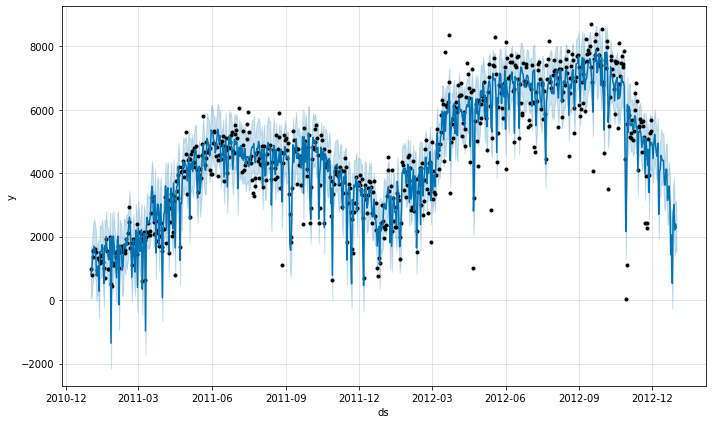

In [ ]:
forecast = m2.predict(X_test)
fig = m2.plot(forecast);

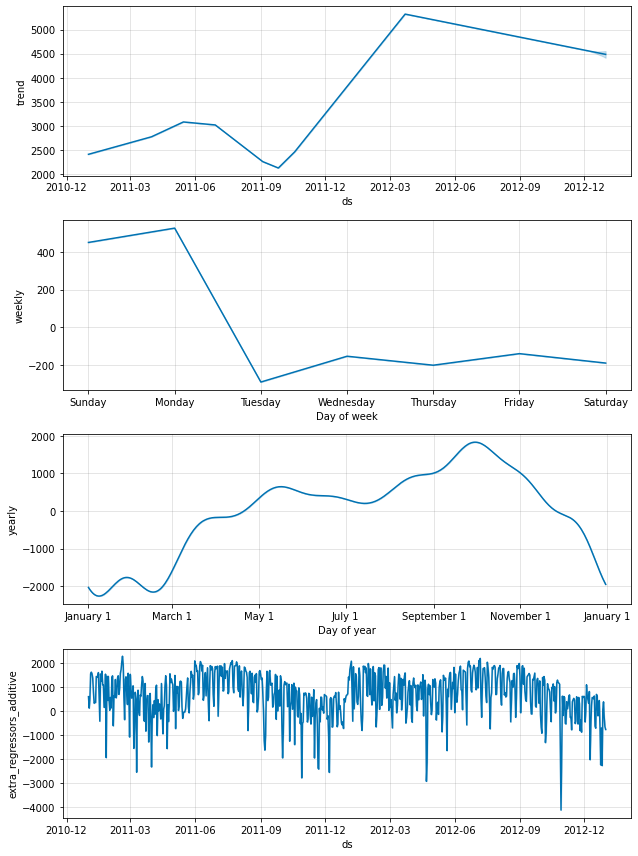

In [ ]:
fig = m2.plot_components(forecast);

In [ ]:
predicted = forecast[forecast.ds>=train_cut].yhat
real = y_test[-len(predicted):]

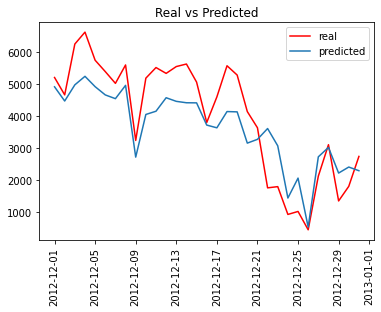

In [ ]:
x = X_test.ds[-len(predicted):]
plt.plot(x,real,c='red',label='real')
plt.plot(x,predicted,label='predicted')
plt.legend()
plt.xticks(rotation='vertical')
plt.title('Real vs Predicted');

In [ ]:
# imprimios evaluación
evaluate(real,predicted)

Mean squared error: 838636.62
Coefficient of determination: 0.73
MAPE: 0.27


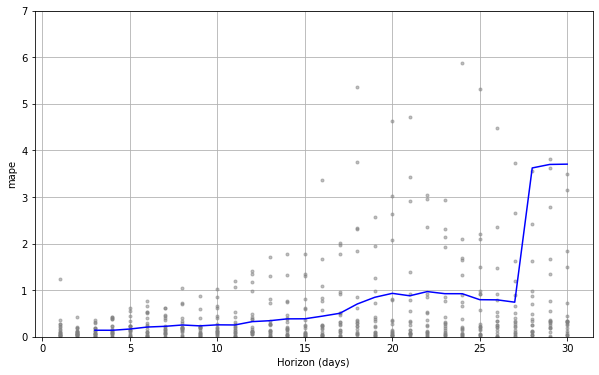

In [ ]:
from fbprophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')
plt.ylim(0,7);

# ANEXO -> Holidays de FbProphet

In [ ]:
import holidays

In [ ]:
for date, name in sorted(holidays.US(state='CO', years=2012).items()):
  print(date, name)

2012-01-01 New Year's Day
2012-01-02 New Year's Day (Observed)
2012-01-16 Martin Luther King Jr. Day
2012-02-20 Washington's Birthday
2012-05-28 Memorial Day
2012-07-04 Independence Day
2012-09-03 Labor Day
2012-10-08 Columbus Day
2012-11-11 Veterans Day
2012-11-12 Veterans Day (Observed)
2012-11-22 Thanksgiving
2012-12-25 Christmas Day
